In [ ]:
!pwd

/content/drive/My Drive/Projects/Training Datasets


In [ ]:
cd /content/drive/MyDrive/Projects/Training Datasets

/content/drive/MyDrive/Projects/Training Datasets


In [ ]:
!nvidia-smi

Sun Sep 12 18:42:10 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.63.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

*Importing Packages*

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm
from PIL import ImageFile #big images present in the dataset so ..

*Assigning Learning rate, EPOCHS and Batch Size*

In [ ]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

DIRECTORY = "dataset2"
CATEGORIES = ["with_mask", "without_mask"]

In [ ]:
print(DIRECTORY)
print(CATEGORIES)

dataset2
['with_mask', 'without_mask']


In [ ]:
ImageFile.LOAD_TRUNCATED_IMAGES = True

*Grabbing and Initializing the images from the 'dataset' directory*

In [ ]:
data = []
labels = []

for category in CATEGORIES:
    path = os.path.join(DIRECTORY, category)
    print("Loading for category %s" % category)
    for img in tqdm(os.listdir(path)):
        img_path = os.path.join(path, img)
        image = load_img(img_path, target_size=(224, 224))
        image = img_to_array(image)
        image = preprocess_input(image)

        data.append(image)
        labels.append(category)

Loading for category with_mask


100%|██████████| 690/690 [02:17<00:00,  5.03it/s]


Loading for category without_mask


100%|██████████| 686/686 [02:14<00:00,  5.09it/s]


*Encoding Labels*

In [ ]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels,
                                                  test_size=0.20, stratify=labels, random_state=42)

*Construct the training image generator for data augmentation*

In [ ]:
aug = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

*Loading the InceptionResNetV2 Network*

In [ ]:
baseModel = InceptionResNetV2(weights="imagenet", include_top=False,
                        input_tensor=Input(shape=(224, 224, 3)))

219070464/219055592 [==============================] - 3s 0us/step


*Constructing the head of the Model that weill be placeed on top of the base Model*

In [ ]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(5, 5))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

*Placing the head FC model on top of the base model (this will become the actual model we will train)*

In [ ]:
model = Model(inputs=baseModel.input, outputs=headModel)

*loop over all layers in the base model and freeze them so they will not be updated during the first training process*

In [ ]:
for layer in baseModel.layers:
    layer.trainable = False

*Compiling the Model*

In [ ]:
print("[INFO] compiling the model...")
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,
              metrics=["accuracy"])

[INFO] compiling the model...


*Train the head of the Network*

In [ ]:
print("[INFO] training the head part...")
H = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    verbose=2)

[INFO] training the head part...
Epoch 1/20
34/34 - 65s - loss: 0.4751 - accuracy: 0.7849 - val_loss: 0.1202 - val_accuracy: 0.9964
Epoch 2/20
34/34 - 20s - loss: 0.1294 - accuracy: 0.9822 - val_loss: 0.0501 - val_accuracy: 1.0000
Epoch 3/20
34/34 - 19s - loss: 0.0829 - accuracy: 0.9869 - val_loss: 0.0324 - val_accuracy: 1.0000
Epoch 4/20
34/34 - 19s - loss: 0.0608 - accuracy: 0.9897 - val_loss: 0.0240 - val_accuracy: 1.0000
Epoch 5/20
34/34 - 20s - loss: 0.0451 - accuracy: 0.9934 - val_loss: 0.0217 - val_accuracy: 1.0000
Epoch 6/20
34/34 - 20s - loss: 0.0435 - accuracy: 0.9926 - val_loss: 0.0167 - val_accuracy: 1.0000
Epoch 7/20
34/34 - 20s - loss: 0.0289 - accuracy: 0.9963 - val_loss: 0.0120 - val_accuracy: 1.0000
Epoch 8/20
34/34 - 20s - loss: 0.0315 - accuracy: 0.9916 - val_loss: 0.0172 - val_accuracy: 0.9964
Epoch 9/20
34/34 - 20s - loss: 0.0207 - accuracy: 0.9963 - val_loss: 0.0085 - val_accuracy: 1.0000
Epoch 10/20
34/34 - 20s - loss: 0.0258 - accuracy: 0.9925 - val_loss: 0.0083

*Making predictions on the testing set*

In [ ]:
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

[INFO] evaluating network...


*for each image in the testing set we need to find the index of the
label with corresponding largest predicted probability*

In [ ]:
predIdxs = np.argmax(predIdxs, axis=1)

*Showing a Formatted Classification report*

In [ ]:
print(classification_report(testY.argmax(axis=1), predIdxs,
                            target_names=lb.classes_))

              precision    recall  f1-score   support

   with_mask       1.00      1.00      1.00       138
without_mask       1.00      1.00      1.00       138

    accuracy                           1.00       276
   macro avg       1.00      1.00      1.00       276
weighted avg       1.00      1.00      1.00       276



*Serialize (Writing)the Model to Local Disk*

In [ ]:
print("[INFO] saving mask detector model...")
model.save("irv2_ds2_mask_detector.hdf5", save_format="h5")

[INFO] saving mask detector model...


*Plotting the training loss and accuracy*

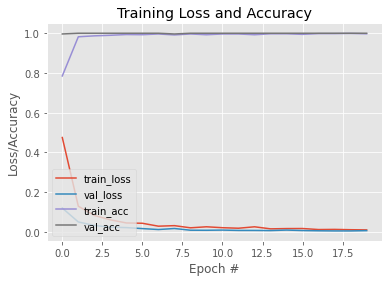

In [ ]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("irv2_ds2_plot.png")